<a href="https://colab.research.google.com/github/hebaashraf21/Classical-and-Deep-Learning-Satellite-Imagery-Change-Detection/blob/main/change_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Add your libraries here
import numpy as np
import glob
import re
import tifffile
from google.colab import drive
import zipfile
import os
import matplotlib.pyplot as plt
from skimage import io
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/MyDrive/trainval.zip'

# Path to extract the dataset
extracted_path = '/content/dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Check the extracted files
extracted_files = os.listdir(extracted_path)
print("Extracted files:", extracted_files)

Mounted at /content/drive
Extracted files: ['trainval']


In [3]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_images(class_name):
    images = []
    dataset_path = '/content/dataset/trainval/'
    class_path = os.path.join(dataset_path, class_name)

    # Use glob to find files matching the pattern '*.png' and sort them numerically
    filenames = sorted(glob.glob(os.path.join(class_path, '*.png')), key=natural_sort_key)

    for filename in filenames:
        image = Image.open(filename)
        images.append(image)

    return images


# Load images for each class
a_images = np.asarray(load_images('A'))
b_images = np.asarray(load_images('B'))
label_images = np.asarray(load_images('label'))

print("Number of A images:", len(a_images))
print("Number of B images:", len(b_images))
print("Number of label images:", len(label_images))

Number of A images: 4868
Number of B images: 4868
Number of label images: 4868


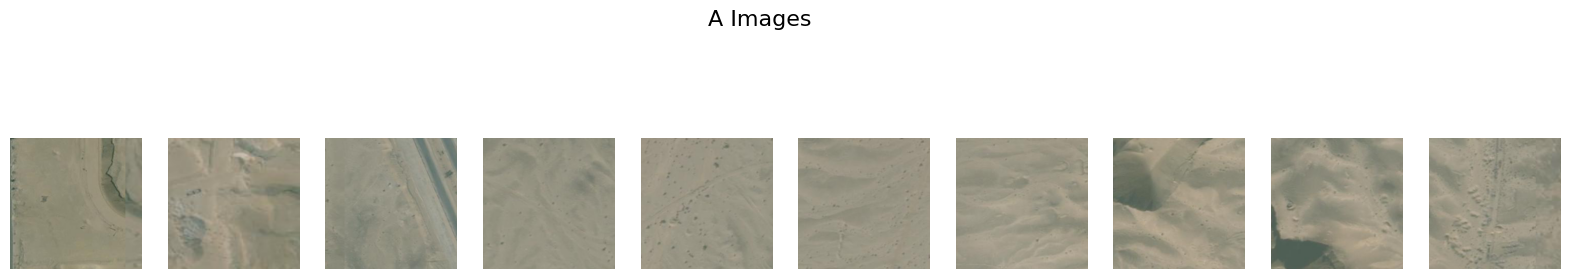

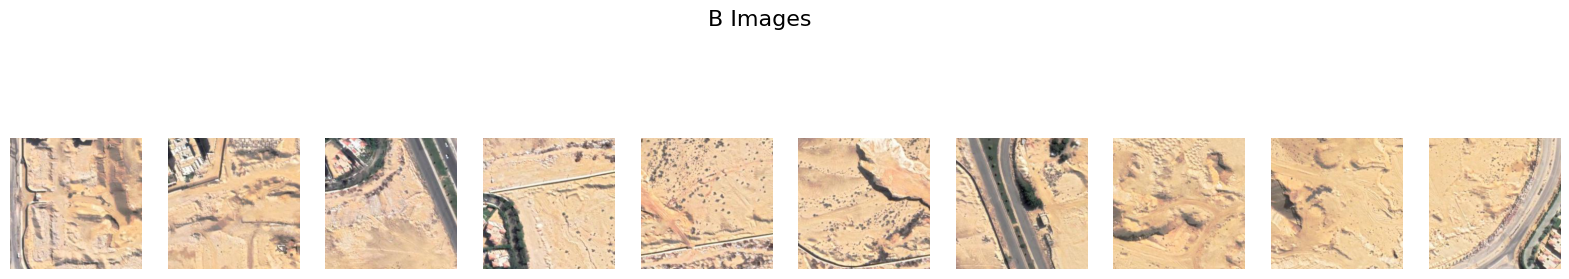

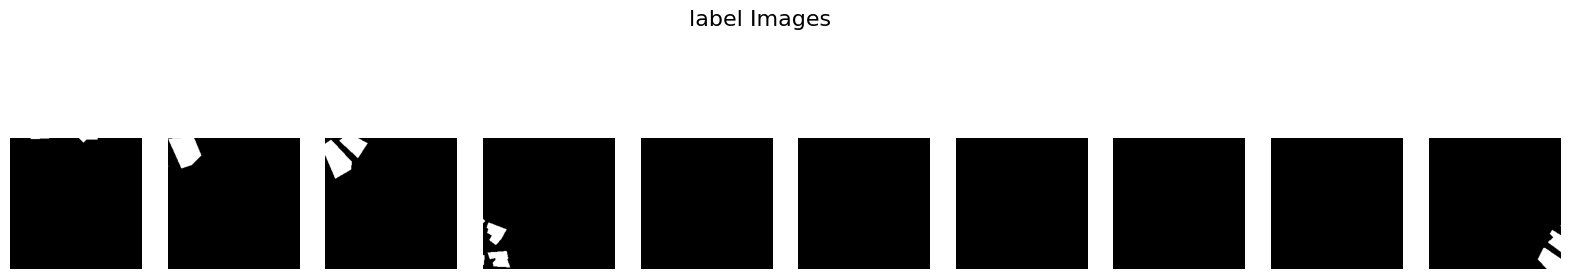

In [4]:
def display_images(images, title):
    fig, axs = plt.subplots(1, 10, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        img_array = np.array(images[i])
        if len(img_array.shape) == 3 and img_array.shape[2] == 4:  # Check if the image has an alpha channel
            img_array = img_array[:, :, :3]  # Display only RGB channels
        if len(img_array.shape) == 2:  # Grayscale image, convert to RGB
            img_array = np.stack((img_array,) * 3, axis=-1)
        axs[i].imshow(img_array)
        axs[i].axis('off')

    plt.show()

display_images(a_images[:10], 'A Images')
display_images(b_images[:10], 'B Images')
display_images(label_images[:10], 'label Images')


In [5]:
print(a_images.shape)
print(b_images.shape)
print(label_images.shape)

(4868, 256, 256, 3)
(4868, 256, 256, 3)
(4868, 256, 256)


In [6]:
def image_difference(image1, image2, threshold=10):
    """Calculate the absolute difference between two images and threshold the result."""
    # Convert color images to grayscale
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if len(image2.shape) == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    diff = np.abs(image1 - image2)
    return np.where(diff >= threshold, 255, 0)


# Define the threshold value
threshold_value = 140  # Adjust as needed

# Apply image differencing with thresholding to the dataset
thresholded_images = []
for a_image, b_image in zip(a_images, b_images):
    difference_image = image_difference(a_image, b_image, threshold=threshold_value)
    thresholded_images.append(difference_image)




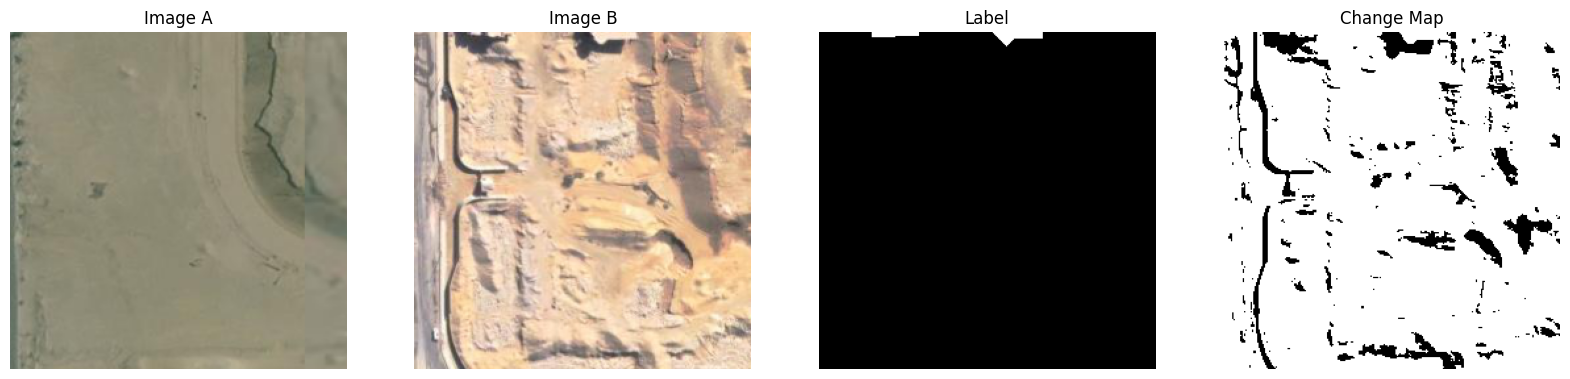

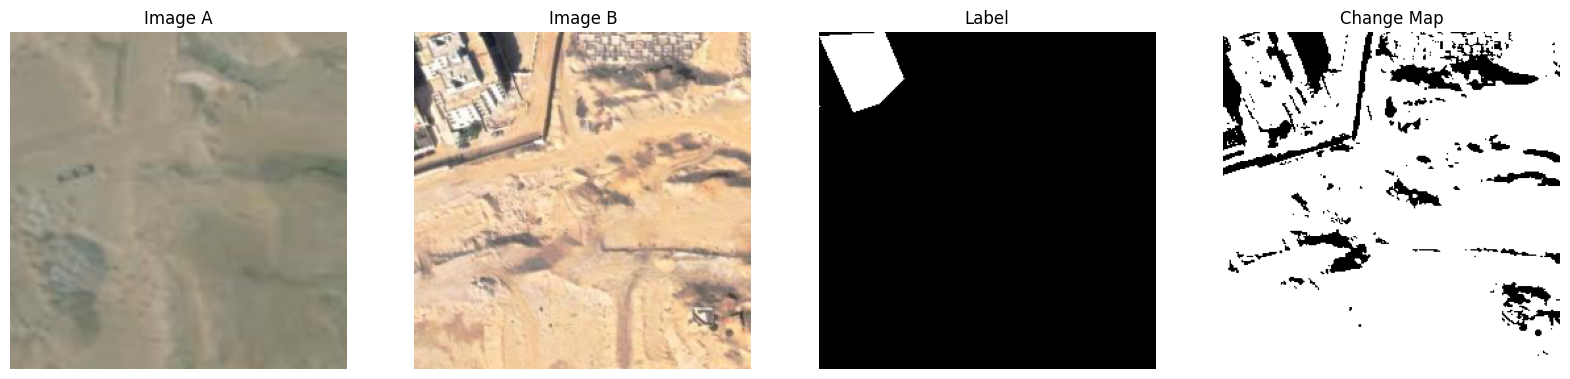

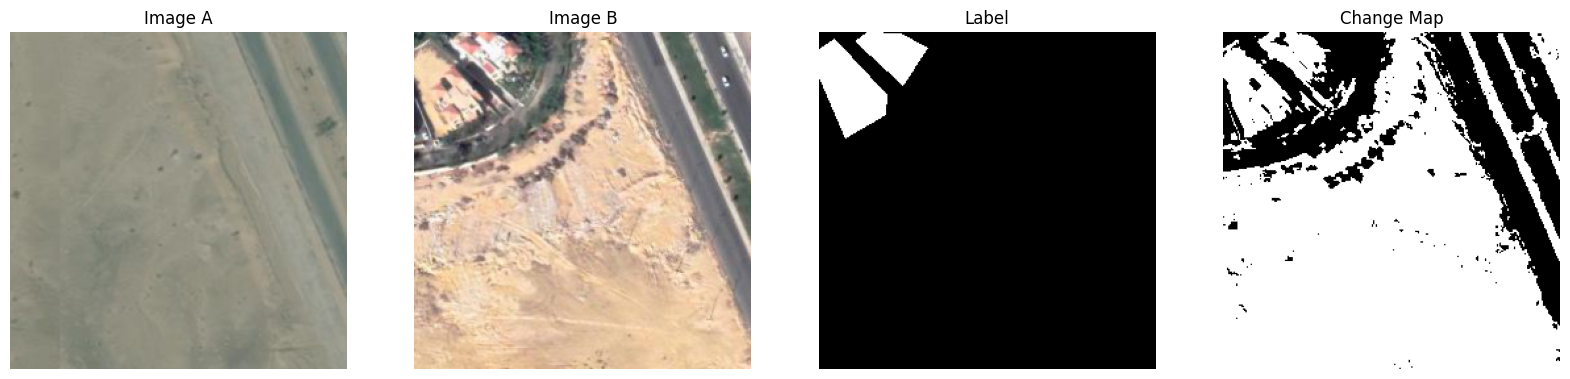

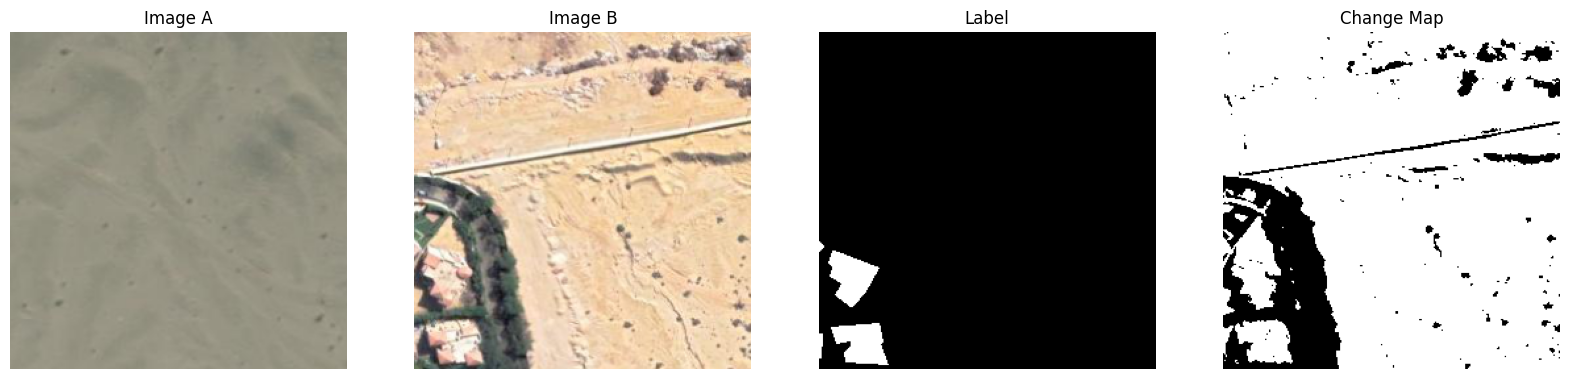

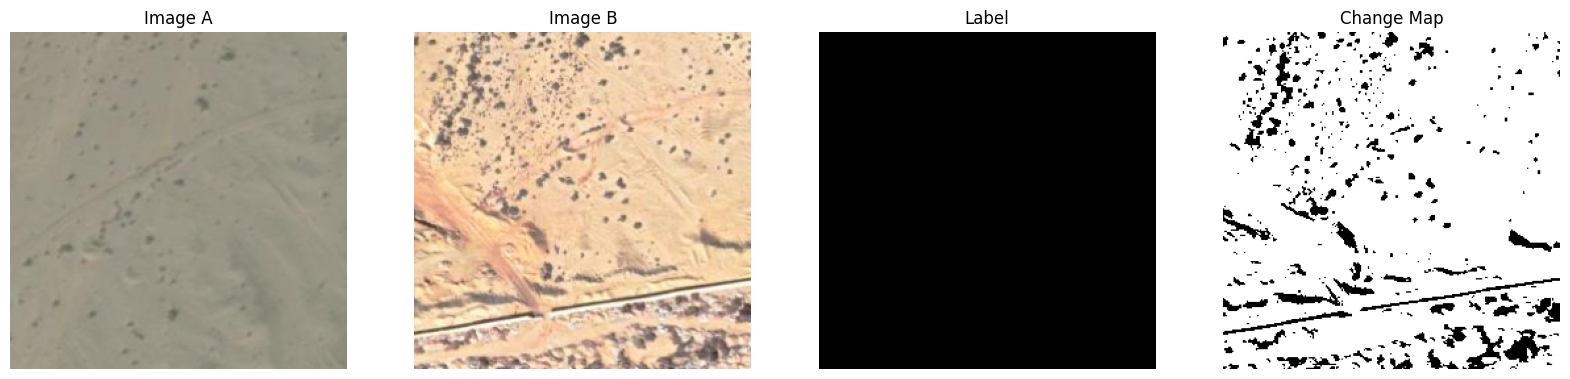

In [7]:
def plot_images(image1, image2, label, change_map):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')
    axes[2].imshow(label, cmap='gray')
    axes[2].set_title('Label')
    axes[2].axis('off')
    axes[3].imshow(change_map, cmap='gray')
    axes[3].set_title('Change Map')
    axes[3].axis('off')
    plt.show()

# Example usage for the first 5 images
for i in range(5):
    plot_images(a_images[i], b_images[i], label_images[i], thresholded_images[i])


In [8]:
def jaccard_index(image1, image2):
    """Calculate the Jaccard Index (Intersection over Union) between two binary images."""
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    if  np.sum(union)==0 and np.sum(intersection)==0:
       return 1
    else:
       return np.sum(intersection) / np.sum(union)
# Compute the Jaccard Index for each pair of images
jaccard_scores = []
for thresholded_image, label_image in zip(thresholded_images, label_images):
    jaccard_score = jaccard_index(thresholded_image, label_image)
    jaccard_scores.append(jaccard_score)

# Average Jaccard Index across all images
average_jaccard_index = np.mean(jaccard_scores)
print(average_jaccard_index*100)

8.215842711996215


In [9]:
'''
threshold=75  ==> score=7.689
threshold=85  ==> score=7.795
threshold=95  ==> score=7.888
threshold=100 ==> score=7.9
threshold=110  ==> score=8.007
threshold=120  ==> score=8.008
threshold=130  ==> score=8.17
threshold=140  ==> score=8.2158
threshold=150  ==> score=8.15
threshold=160  ==> score=7.9
threshold=200  ==> score=5.958
'''

'\nthreshold=75  ==> score=7.689\nthreshold=85  ==> score=7.795\nthreshold=95  ==> score=7.888\nthreshold=100 ==> score=7.9\nthreshold=110  ==> score=8.007\nthreshold=120  ==> score=8.008\nthreshold=130  ==> score=8.17\nthreshold=140  ==> score=8.2158\nthreshold=150  ==> score=8.15\nthreshold=160  ==> score=7.9\nthreshold=200  ==> score=5.958\n'

In [10]:
def split_images(images, test_size=0.2, random_state=42):
    train_images, val_images = train_test_split(images, test_size=test_size, random_state=random_state)
    return train_images, val_images

# Split images for each class
a_train_images, a_val_images = split_images(a_images)
b_train_images, b_val_images = split_images(b_images)
label_train_images, label_val_images = split_images(label_images)

print("Number of A train images:", len(a_train_images))
print("Number of A validation images:", len(a_val_images))
print("Number of B train images:", len(b_train_images))
print("Number of B validation images:", len(b_val_images))
print("Number of label train images:", len(label_train_images))
print("Number of label validation images:", len(label_val_images))

Number of A train images: 3894
Number of A validation images: 974
Number of B train images: 3894
Number of B validation images: 974
Number of label train images: 3894
Number of label validation images: 974
